In [67]:
from pyspark.sql import SparkSession
from pathlib import Path
import pyspark.sql.functions as func
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum as _sum


def read_parquet_file(spark, file_path):
    df = spark.read.parquet(file_path)
    return df


def is_hdfs_file_exist(path):
    proc = subprocess.Popen(['hadoop', 'fs', '-test', '-e', path])
    proc.communicate()
    return proc.returncode == 0


def add_index_to_dataframe(df):
    return df.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())))



spark = SparkSession.builder.appName('lr_example').getOrCreate()

# Load data
hdfs_host = "hdfs://localhost:9000"
hdfs_root_path = "/SafeEntry_Analytics/"
case_file_dest = "case_daily_summary.parquet"

all_data = read_parquet_file(spark, hdfs_host+hdfs_root_path+case_file_dest)
all_data.printSchema()



root
 |-- date: string (nullable = true)
 |-- dailyConfirmed: integer (nullable = true)



In [68]:
cases_group_by_date = all_data.withColumn("dayOfWeek", func.dayofweek(all_data["date"]))
cases_group_by_date = add_index_to_dataframe(cases_group_by_date)
cases_group_by_date.show()
cases_group_by_date.printSchema()

+----------+--------------+---------+-----+
|      date|dailyConfirmed|dayOfWeek|index|
+----------+--------------+---------+-----+
|2020-01-23|             1|        5|    1|
|2020-01-24|             2|        6|    2|
|2020-01-25|             1|        7|    3|
|2020-01-26|             0|        1|    4|
|2020-01-27|             1|        2|    5|
|2020-01-28|             2|        3|    6|
|2020-01-29|             3|        4|    7|
|2020-01-30|             3|        5|    8|
|2020-01-31|             3|        6|    9|
|2020-02-01|             2|        7|   10|
|2020-02-02|             0|        1|   11|
|2020-02-03|             0|        2|   12|
|2020-02-04|             6|        3|   13|
|2020-02-05|             4|        4|   14|
|2020-02-06|             2|        5|   15|
|2020-02-07|             3|        6|   16|
|2020-02-08|             7|        7|   17|
|2020-02-09|             3|        1|   18|
|2020-02-10|             2|        2|   19|
|2020-02-11|             2|     

Text(0, 0.5, 'Count')

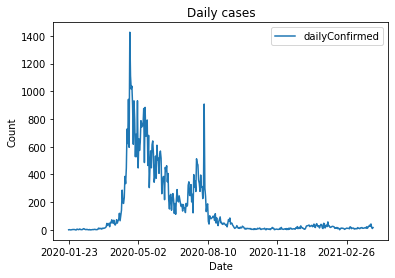

In [56]:
cases_group_by_date.toPandas().plot(x="date", y="dailyConfirmed")
plt.title("Daily cases")
plt.xlabel("Date")
plt.ylabel("Count")

+---------+-------------------+
|dayOfWeek|sum(dailyConfirmed)|
+---------+-------------------+
|        1|               8823|
|        2|               8083|
|        3|               8105|
|        4|               9512|
|        5|               8698|
|        6|               9152|
|        7|               8202|
+---------+-------------------+



<AxesSubplot:>

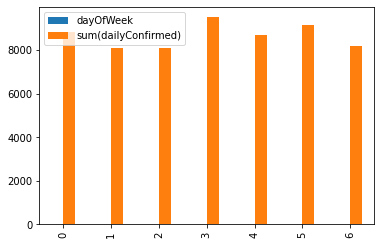

In [70]:

#cases_group_by_date.select("count").distinct().show()
cases_group_by_day_of_week = cases_group_by_date\
                        .groupby(['dayOfWeek'])\
                        .agg(_sum('dailyConfirmed'))\
                        .orderBy('dayOfWeek',asending=True)
cases_group_by_day_of_week.show()

cases_group_by_day_of_week.toPandas().plot(kind='bar')


In [83]:
# Split into training data and test data
total_count = cases_group_by_date.count()
seventy_percent_index = round(total_count * 0.8)
cases_group_by_date.registerTempTable("daily_cases")
train_data = spark.sql("select * from daily_cases where index <= {}".format(seventy_percent_index))
test_data = spark.sql("select * from daily_cases where index > {}".format(seventy_percent_index))
train_data.show()
test_data.show()

+----------+--------------+---------+-----+
|      date|dailyConfirmed|dayOfWeek|index|
+----------+--------------+---------+-----+
|2020-01-23|             1|        5|    1|
|2020-01-24|             2|        6|    2|
|2020-01-25|             1|        7|    3|
|2020-01-26|             0|        1|    4|
|2020-01-27|             1|        2|    5|
|2020-01-28|             2|        3|    6|
|2020-01-29|             3|        4|    7|
|2020-01-30|             3|        5|    8|
|2020-01-31|             3|        6|    9|
|2020-02-01|             2|        7|   10|
|2020-02-02|             0|        1|   11|
|2020-02-03|             0|        2|   12|
|2020-02-04|             6|        3|   13|
|2020-02-05|             4|        4|   14|
|2020-02-06|             2|        5|   15|
|2020-02-07|             3|        6|   16|
|2020-02-08|             7|        7|   17|
|2020-02-09|             3|        1|   18|
|2020-02-10|             2|        2|   19|
|2020-02-11|             2|     

In [84]:
# These are the default values for the featuresCol, labelCol, predictionCol
vectorAssembler = VectorAssembler(inputCols=["index"], outputCol="features")
train_sub = vectorAssembler.transform(train_data)
test_sub = vectorAssembler.transform(test_data)

lr = LinearRegression(featuresCol='features',labelCol='dailyConfirmed',predictionCol='prediction')
# Fit the model
lr_model = lr.fit(train_sub)
# Print the coefficients and intercept training data
print("Coefficients: {}".format(str(lr_model.coefficients)))
print("Intercept: {}".format(str(lr_model.intercept)))

Coefficients: [-0.7100838050838051]
Intercept: 292.7610744810745


Text(0, 0.5, 'Count')

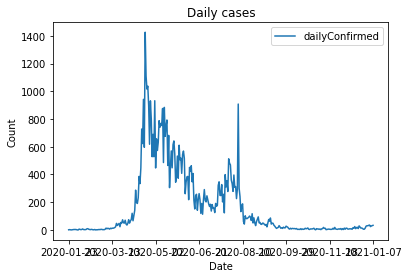

In [85]:
train_data.toPandas().plot(x="date", y="dailyConfirmed")
plt.title("Daily cases")
plt.xlabel("Date")
plt.ylabel("Count")

In [86]:
# Testing result
test_result = lr_model.evaluate(test_sub)
test_result.residuals.show()
print("RMSE: {}".format(test_result.rootMeanSquaredError))

+-------------------+
|          residuals|
+-------------------+
|-19.811575091575122|
|-13.101491286491296|
| 0.6085925185925021|
|  -18.6813236763237|
|-22.971239871239902|
| -1.261156066156076|
|  6.448927738927722|
|  -7.84098845598848|
|-13.130904650904682|
| -6.420820845820856|
|-21.710737040737058|
|  -5.00065323565326|
|  5.709430569430538|
| 4.4195143745143355|
|-17.870401820401867|
|-22.160318015318012|
| 16.549765789765786|
| 13.259849594849584|
| -16.03006660006662|
|-4.3199827949828205|
+-------------------+
only showing top 20 rows

RMSE: 18.175904023667492


In [87]:
# Prediction
predictions = lr_model.transform(test_sub)
predictions = predictions.withColumn("prediction",func.round(predictions["prediction"]))
predictions.show()


+----------+--------------+---------+-----+--------+----------+
|      date|dailyConfirmed|dayOfWeek|index|features|prediction|
+----------+--------------+---------+-----+--------+----------+
|2021-01-08|            23|        6|  352| [352.0]|      43.0|
|2021-01-09|            29|        7|  353| [353.0]|      42.0|
|2021-01-10|            42|        1|  354| [354.0]|      41.0|
|2021-01-11|            22|        2|  355| [355.0]|      41.0|
|2021-01-12|            17|        3|  356| [356.0]|      40.0|
|2021-01-13|            38|        4|  357| [357.0]|      39.0|
|2021-01-14|            45|        5|  358| [358.0]|      39.0|
|2021-01-15|            30|        6|  359| [359.0]|      38.0|
|2021-01-16|            24|        7|  360| [360.0]|      37.0|
|2021-01-17|            30|        1|  361| [361.0]|      36.0|
|2021-01-18|            14|        2|  362| [362.0]|      36.0|
|2021-01-19|            30|        3|  363| [363.0]|      35.0|
|2021-01-20|            40|        4|  3

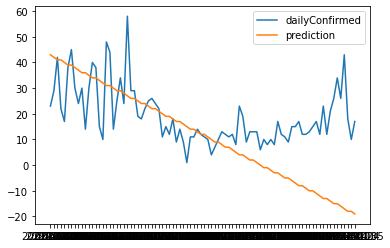

In [88]:
predictionsPandas = predictions.toPandas()

plt.plot( 'date', 'dailyConfirmed', data=predictionsPandas, marker='')
plt.plot( 'date', 'prediction', data=predictionsPandas, marker='')

# show legend
plt.legend()
# show graph
plt.show()
